# Simple Sentence Similarity (from github) - with application of the methods to a sample dataset at the end

Word embeddings have become widespread in Natural Language Processing. They allow us to easily compute the semantic similarity between two words, or to find the words most similar to a target word. However, in many applications we're more interested in the similarity between two sentences or short texts. In this notebook, I compare some simple ways of computing sentence similarity and investigate how they perform.

## Data

### STS Benchmark

The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark


In [55]:
FULL = False
WITH_GLOVE = False

In [56]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def load_sts_dataset(filename):
    # Loads a subset of the STS dataset into a DataFrame. In particular both
    # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)

    sts_dev = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test

sts_dev, sts_test = download_and_load_sts_data()

In [57]:
sts_test[:5]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


### SICK data

The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [58]:
import requests

def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = sick_train.append(sick_test).append(sick_dev)

In [60]:
sick_all[:5]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


## Preparation

First we need to do some preparation: some of our models require the sentences to be tokenized, some do not. For that reason we'll make a simple Sentence class where we keep both the raw sentence and the tokenized sentence. The individual methods below will then pick the input they need.

In [61]:
import nltk

STOP = set(nltk.corpus.stopwords.words("english"))

class Sentence:
    
    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_without_stop = [t for t in self.tokens if t not in STOP]

Next, we're going to use the popular [Gensim](https://radimrehurek.com/gensim/) library to load two sets of widely used pre-trained word embeddings: 
[word2vec](https://www.tensorflow.org/tutorials/word2vec) and [GloVe](https://nlp.stanford.edu/projects/glove/). 

In [62]:
import gensim

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

PATH_TO_WORD2VEC = os.path.expanduser("/home/trickster_ks/jupy/GoogleNews-vectors-negative300.bin")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(PATH_TO_WORD2VEC, binary=True, limit=500000)

To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model. This will take some time.

In [9]:
if FULL and WITH_GLOVE:
    tmp_file = "/tmp/glove.840B.300d.w2v.txt"
    PATH_TO_GLOVE = os.path.expanduser("glove.840B.300d.txt")
    glove2word2vec(PATH_TO_GLOVE, tmp_file)
    glove = gensim.models.KeyedVectors.load_word2vec_format(tmp_file, limit = 300000)

Finally, in order to compute weighted averages of word embeddings later, we are going to load a file with word frequencies. These word frequencies have been collected from Wikipedia and saved in a tab-separated file. 

In [11]:
import csv

PATH_TO_FREQUENCIES_FILE = "frequencies/sentence_similarity/frequencies.tsv"
PATH_TO_DOC_FREQUENCIES_FILE = "frequencies/sentence_similarity/doc_frequencies.tsv"

def read_tsv(f):
    frequencies = {}
    with open(f) as tsv:
        tsv_reader = csv.reader(tsv, delimiter="\t")
        for row in tsv_reader: 
            frequencies[row[0]] = int(row[1])
        
    return frequencies
        
frequencies = read_tsv(PATH_TO_FREQUENCIES_FILE)
doc_frequencies = read_tsv(PATH_TO_DOC_FREQUENCIES_FILE)
doc_frequencies["NUM_DOCS"] = 1288431


## Similarity methods

### Baseline

As our baseline, we're going for the simplest way of computing sentence embeddings: just take the embeddings of the words in the sentence (minus the stopwords), and compute their average, weighted by the sentence frequency of each word. 

We then use the cosine to calculate the similarity between two sentence embeddings.

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math

def run_avg_benchmark(sentences1, sentences2, model=None, use_stoplist=False, doc_freqs=None): 

    if doc_freqs is not None:
        N = doc_freqs["NUM_DOCS"]
    
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):
    
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens

        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        if len(tokens1) == 0 or len(tokens2) == 0:
            sims.append(0)
            continue
        
        tokfreqs1 = Counter(tokens1)
        tokfreqs2 = Counter(tokens2)
        
        weights1 = [tokfreqs1[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                    for token in tokfreqs1] if doc_freqs else None
        weights2 = [tokfreqs2[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                    for token in tokfreqs2] if doc_freqs else None
                
        embedding1 = np.average([model[token] for token in tokfreqs1], axis=0, weights=weights1).reshape(1, -1)
        embedding2 = np.average([model[token] for token in tokfreqs2], axis=0, weights=weights2).reshape(1, -1)

        sim = cosine_similarity(embedding1, embedding2)[0][0]
        sims.append(sim)

    return sims

### Word Mover's Distance

Word mover's distance is a popular alternative to the simple average embedding similarity. The Word Mover's Distance uses the word embeddings of the words in two texts to measure the minimum amount that the words in one text need to "travel" in semantic space to reach the words of the other text. Word mover's distance is available in the popular Gensim library.

In [13]:
def run_wmd_benchmark(sentences1, sentences2, model, use_stoplist=False):
    
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):
    
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        if len(tokens1) == 0 or len(tokens2) == 0:
            tokens1 = [token for token in sent1.tokens if token in model]
            tokens2 = [token for token in sent2.tokens if token in model]
            
        sims.append(-model.wmdistance(tokens1, tokens2))
        
    return sims

### Smooth Inverse Frequency

Taking the average of the word embeddings in a sentence, like we did above, is a very crude method of computing sentence embeddings. Most importantly, this gives far too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem. 

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by `a/a+p(w)`, where `w` is a parameter that is set to `0.001` by default, and `p(w)` is the estimated relative frequency of a word in a reference corpus.

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc. 

In [14]:
from sklearn.decomposition import TruncatedSVD

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX


def run_sif_benchmark(sentences1, sentences2, model, freqs={}, use_stoplist=False, a=0.001): 
    total_freq = sum(freqs.values())
    
    embeddings = []
    
    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    for (sent1, sent2) in zip(sentences1, sentences2): 
        
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
        weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
        embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
        embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
        
        embeddings.append(embedding1)
        embeddings.append(embedding2)
        
    embeddings = remove_first_principal_component(np.array(embeddings))
    sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                              embeddings[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings)/2))]

    return sims

The methods above share two important characteristics: 

- As simple bag-of-word methods, they do take not word order into account.
- The word embeddings they use have been learned in an unsupervised manner. 

Both these characteristics are potential downsides: 

- Since differences in word order can point to differences in meaning (compare `the dog bites the man` with `the man bites the dog`), we'd like our sentence embeddings to be sensitive to this variation.
- Supervised training can help sentence embeddings learn the meaning of a sentence more directly.

We can achieve both points by using a pre-trained sentence encoder to produce our sentence embeddings. Several such encoders are available. We'll investigate InferSent and the Google Sentence Encoder.

### InferSent

[InferSent](https://github.com/facebookresearch/InferSent) is a pre-trained encoder that produces sentence embeddings. 
More particularly, it is a BiLSTM with max pooling that was trained on the SNLI dataset, 570k English sentence pairs labelled with one of three categories: entailment, contradiction or neutral. InferSent was developed and trained by Facebook Research.

Let's first download the resources we need.

In [15]:
if FULL:    
    !wget -nc https://raw.githubusercontent.com/facebookresearch/InferSent/master/models.py
    # !wget -nc https://s3.amazonaws.com/senteval/infersent/infersent.allnli.pickle
    !curl -Lo encoder/infersent1.pkl https://s3.amazonaws.com/senteval/infersent/infersent1.pkl

Then we load the model.

In [16]:
if FULL:
    import torch
    from models import InferSent
    V = 1
    MODEL_PATH = 'encoder/infersent1.pkl'
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
    infersent = InferSent(params_model)
    infersent.load_state_dict(torch.load(MODEL_PATH))
    infersent.set_w2v_path(PATH_TO_GLOVE)

In [17]:
# import torch
# # infersent = torch.load('infersent.allnli.pickle')

# infersent = torch.load('infersent.allnli.pickle', map_location=lambda storage, loc: storage)
# infersent.use_cuda = False
# infersent.set_glove_path(PATH_TO_GLOVE)

Finally, we can run the benchmark by having InferSent encode the two sets of sentences and compute the cosine similarity between the corresponding sentences.

In [18]:
def run_inf_benchmark(sentences1, sentences2):
    
    raw_sentences1 = [sent1.raw for sent1 in sentences1]
    raw_sentences2 = [sent2.raw for sent2 in sentences2]
    
    infersent.build_vocab(raw_sentences1 + raw_sentences2, tokenize=True)
    embeddings1 = infersent.encode(raw_sentences1, tokenize=True)
    embeddings2 = infersent.encode(raw_sentences2, tokenize=True)
    
    inf_sims = []
    for (emb1, emb2) in zip(embeddings1, embeddings2): 
        sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
        inf_sims.append(sim)

    return inf_sims   

### Google Sentence Encoder

The [Google Sentence Encoder](https://www.tensorflow.org/hub/modules/google/universal-sentence-encoder/1) is Google's answer to Facebook's InferSent. It comes in two forms: 

- a Transformer model that takes the element-wise sum of the context-aware word representations produced by the encoding subgraph of a Transformer model.
- a Deep Averaging Network (DAN) where input embeddings for words and bigrams are averaged together and passed through a feed-forward deep neural network.

The Transformer model tends to give better results, but at the time of writing, only the DAN-based encoder was available.

In contrast to InferSent, the Google Sentence Encoder was trained on a combination of unsupervised data (in a skip-thought-like task) and supervised data (the SNLI corpus).

The Google Sentence Encoder can be loaded from the Tensorflow Hub.

In [19]:
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

Like InferSent above, we'll have the it encode the two sets of sentences and return the similarities between the embeddings it produced.

In [20]:
def run_gse_benchmark(sentences1, sentences2):
    sts_input1 = tf.placeholder(tf.string, shape=(None))
    sts_input2 = tf.placeholder(tf.string, shape=(None))

    sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
    sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
        
    sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
      
        [gse_sims] = session.run(
            [sim_scores],
            feed_dict={
                sts_input1: [sent1.raw for sent1 in sentences1],
                sts_input2: [sent2.raw for sent2 in sentences2]
            })
    return gse_sims


## Experiments

Finally, it's time to run the actual experiments. 

In [21]:
def run_experiment(df, benchmarks): 
    
    sentences1 = [Sentence(s) for s in df['sent_1']]
    sentences2 = [Sentence(s) for s in df['sent_2']]
    
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        pearson_correlation = scipy.stats.pearsonr(sims, df['sim'])[0]
        print(label, pearson_correlation)
        pearson_cors.append(pearson_correlation)
        spearman_correlation = scipy.stats.spearmanr(sims, df['sim'])[0]
        spearman_cors.append(spearman_correlation)
        
    return pearson_cors, spearman_cors

In [22]:
import functools as ft

benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequencies)),
              ("AVG-W2V-TFIDF-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequencies)),
              ("WMD-W2V", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=False)), 
              ("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False)),
              ("GSE", run_gse_benchmark)
             ]

if WITH_GLOVE: benchmark += [
    ("SIF-GLOVE", ft.partial(run_sif_benchmark, freqs=frequencies, model=glove, use_stoplist=False)), 
    ("AVG-GLOVE-TFIDF-STOP", ft.partial(run_avg_benchmark, model=glove, use_stoplist=True, doc_freqs=doc_frequencies)),
    ("WMD-GLOVE-STOP", ft.partial(run_wmd_benchmark, model=glove, use_stoplist=True)), 
    ("WMD-GLOVE", ft.partial(run_wmd_benchmark, model=glove, use_stoplist=False)),
    ("AVG-GLOVE", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False)),
    ("AVG-GLOVE-STOP", ft.partial(run_avg_benchmark, model=glove, use_stoplist=True)),
    ("AVG-GLOVE-TFIDF", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False, doc_freqs=doc_frequencies)),   
]
if FULL: benchmark.append(("INF", run_inf_benchmark))


global PYEMD_EXT
pearson_results, spearman_results = {}, {}
pearson_results["SICK-DEV"], spearman_results["SICK-DEV"] = run_experiment(sick_dev, benchmarks)
if FULL:
    pearson_results["SICK-TEST"], spearman_results["SICK-TEST"] = run_experiment(sick_test, benchmarks)
    pearson_results["STS-DEV"], spearman_results["STS-DEV"] = run_experiment(sts_dev, benchmarks)
    pearson_results["STS-TEST"], spearman_results["STS-TEST"] = run_experiment(sts_test, benchmarks)  


AVG-W2V 0.7160297131633951
AVG-W2V-STOP 0.7006594956785003
AVG-W2V-TFIDF 0.7087075918706278
AVG-W2V-TFIDF-STOP 0.6976394325608488
WMD-W2V 0.6475827561855909
SIF-W2V 0.7248373288728335


## Results

Let's take a look at our results. We'll mostly work with Pearson correlation, as is standard in the literature, except where Spearman correlation sheds additional light on our findings.

In [23]:
plt.rcParams['figure.figsize'] = (10,5)

pearson_results_df = pd.DataFrame(pearson_results)
pearson_results_df = pearson_results_df.transpose()
pearson_results_df = pearson_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})

spearman_results_df = pd.DataFrame(spearman_results)
spearman_results_df = spearman_results_df.transpose()
spearman_results_df = spearman_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})



### Baselines

- Simple word2vec embeddings outperform GloVe embeddings.
- With word2vec, it's unclear whether using a stoplist or tf-idf weighting helps. With STS it sometimes does; with SICK it does not. Simply computing an unweighted average of all word2vec embeddings consistently performs pretty well.
- With GloVe, using a stoplist looks like a very good idea. Using tf-idf weights does not help, with or without a stoplist.

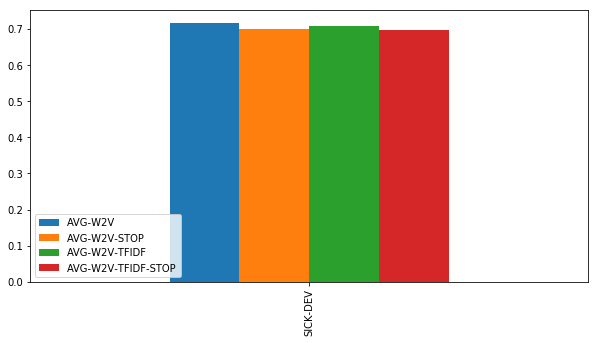

In [24]:
pearson_results_df[[b[0] for b in benchmarks if b[0].startswith("AVG")]].plot(kind="bar").legend(loc="lower left")

### Word Mover's Distance

Based on our results, there's little reason to use Word Mover's Distance rather than simple word2vec averages. Only on STS-TEST, and only in combination with a stoplist, does WMD clearly leave the baselines behind.

In [ ]:
pearson_results_df[["AVG-W2V", "WMD-W2V", "WMD-W2V-STOP", "AVG-GLOVE-STOP", "WMD-GLOVE", "WMD-GLOVE-STOP"]].plot(kind="bar").legend(loc="lower left")

### Smooth Inverse Frequency

Smooth Inverse Frequency is the most consistent performer in our tests. On the SICK data, it does about as well as its baseline competitors, on STS it outranks them by a clear margin. Note there is little difference between SIF with word2vec embeddings and SIF with GloVe embeddings. This is remarkable, given the large differences we observed above. It shows SIF's weighting and common component removal is a very effective alternative to using a stoplist.

In [ ]:
pearson_results_df[["AVG-W2V", "AVG-GLOVE-STOP", "SIF-W2V", "SIF-GLOVE"]].plot(kind="bar").legend(loc="lower left")

### Pretrained encoders

Pre-trained encoders have a lot to be said for them. However, our results indicate they are not yet able to capitalize fully on their training regime. Throughout our tests, Google's Sentence Encoder looks like a better choice than InferSent. However, the Pearson correlation coefficient shows very little difference with Smooth Inverse Frequency. The differences in Spearman correlation are more outspoken. This may indicate that the Google Sentence Encoder more often gets the relative ordering of the sentences right, but not necessarily the relative differences between them.

In [ ]:
pearson_results_df[["SIF-W2V", "INF", "GSE"]].plot(kind="bar").legend(loc="lower left")
spearman_results_df[["SIF-W2V", "INF", "GSE"]].plot(kind="bar").legend(loc="lower left")

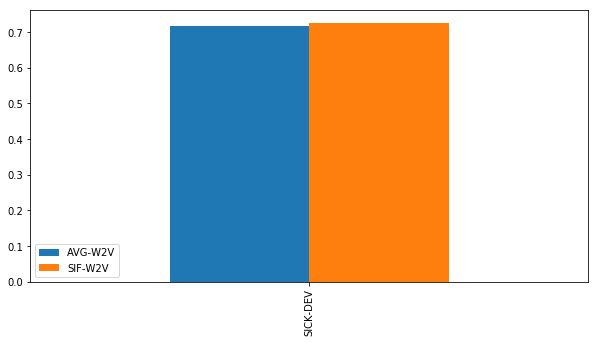

In [33]:
pearson_results_df[["AVG-W2V", "SIF-W2V"]].plot(kind="bar").legend(loc="lower left")

## Conclusions

These are the most important conclusions:

- When you're computing sentence similarity, word2vec embeddings are a safer choice than GloVe embeddings.
- Although an unweighted average of the word embeddings in the sentence holds its own as a simple baseline, Smooth Inverse Frequency is usually a stronger alternative.
- When you can use a pre-trained encoder, pick Google's Sentence Encoder, but remember its performance gain may not be all that spectacular.

### Putting it all together

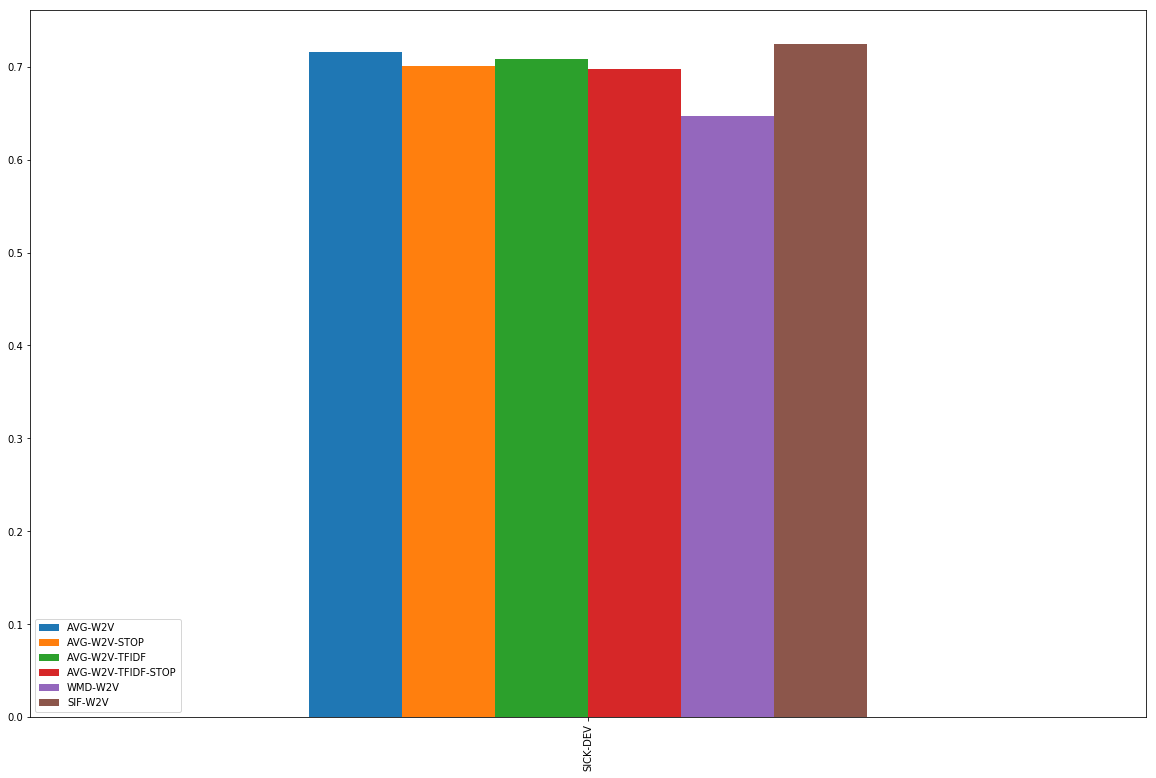

In [52]:
plt.rcParams['figure.figsize'] = (20,13)
pearson_results_df.plot(kind="bar").legend(loc="lower left")

### Application to our dataset

In [28]:
def run_all(df, benchmarks): 
    
    sentences1 = [Sentence(s) for s in df['Field_en']]
    sentences2 = [Sentence(s) for s in df['Field_correct_en']]
    sims = {"Sent1":sentences1, "Sent2": sentences2}
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims[label] = method(sentences1, sentences2)

    frame = pd.DataFrame(sims)    
    return frame

In [27]:
exp_frame = pd.read_csv('Example_dataset_marble - 5_column_with_correct.csv')
exp_frame

,Field,Field_correct,Field_en,Field_correct_en,Accuracy_score,Code,Fieldname
0,liften gaan vast zitten,Centrale verwarming,elevators get stuck,Central heating,4,g,Beton;Field1
1,Beton krimpt als het warm word,Centrale verwarming,Concrete shrinks as the hot word,Central heating,3,g,Beton;Field1
2,Door de centrale verwarming krimpt het beton,Centrale verwarming,By heating the concrete shrinks,Central heating,3,g,Beton;Field1
3,betonnen gebouwen krimpen bij centrale verwarming,Centrale verwarming,concrete buildings shrink by central heating,Central heating,3,g,Beton;Field1
4,beton wordt na een tijdje kleiner,Centrale verwarming,concrete decreases after a while,Central heating,3,g,Beton;Field1
5,beton kan krimpen,Centrale verwarming,can shrink concrete,Central heating,3,g,Beton;Field1
6,betonnen gebouwen krimpen,Centrale verwarming,shrink concrete buildings,Central heating,3,g,Beton;Field1
7,Gebouwen worden van beton gemaakt maar mensen ...,Centrale verwarming,Buildings made of concrete but people did not ...,Central heating,3,g,Beton;Field1
8,Beton krimpt als het warm wordt,Centrale verwarming,Concrete shrinks as it gets hot,Central heating,3,g,Beton;Field1
9,gebouwen v beton worden kleiner door warmte,Centrale verwarming,v concrete buildings become smaller heat,Central heating,3,g,Beton;Field1


In [39]:
# res = run_all(exp_frame, benchmarks)
# res

In [54]:
df = exp_frame
sentences1 = [Sentence(s) for s in df['Field_en']]
sentences2 = [Sentence(s) for s in df['Field_correct_en']]
sims = {"Sent1":sentences1, "Sent2": sentences2}
sims["Sent2"][:5]

In [34]:
for label, method in benchmarks[:-2]:
    sims[label] = method(sentences1, sentences2)

frame = pd.DataFrame(sims) 

In [ ]:

frame["Sent1"] = df['Field_en']
frame["Sent2"] = df['Field_correct_en']
frame = pd.concat([frame, df[["Accuracy_score","Code","Fieldname"]]], axis=1)

In [63]:
frame = frame[['Fieldname','Sent1', 'Sent2','AVG-W2V', 'AVG-W2V-STOP', 'AVG-W2V-TFIDF', 'AVG-W2V-TFIDF-STOP',
                 'WMD-W2V', 'Accuracy_score','Code']]
frame

,Fieldname,Sent1,Sent2,AVG-W2V,AVG-W2V-STOP,AVG-W2V-TFIDF,AVG-W2V-TFIDF-STOP,WMD-W2V,Accuracy_score,Code
0,Beton;Field1,elevators get stuck,Central heating,0.231294,0.231294,0.228077,0.228077,-3.534751,4,g
1,Beton;Field1,Concrete shrinks as the hot word,Central heating,0.318235,0.285322,0.290797,0.287325,-3.321186,3,g
2,Beton;Field1,By heating the concrete shrinks,Central heating,0.604557,0.622755,0.629217,0.629030,-2.572936,3,g
3,Beton;Field1,concrete buildings shrink by central heating,Central heating,0.715484,0.735000,0.706794,0.707927,-2.330719,3,g
4,Beton;Field1,concrete decreases after a while,Central heating,0.227569,0.223106,0.217772,0.212371,-3.352016,3,g
5,Beton;Field1,can shrink concrete,Central heating,0.234531,0.223640,0.220051,0.210751,-3.556463,3,g
6,Beton;Field1,shrink concrete buildings,Central heating,0.291969,0.291969,0.262845,0.262845,-3.664545,3,g
7,Beton;Field1,Buildings made of concrete but people did not ...,Central heating,0.343209,0.405980,0.386122,0.391358,-3.249336,3,g
8,Beton;Field1,Concrete shrinks as it gets hot,Central heating,0.319516,0.312477,0.294888,0.292812,-3.357668,3,g
9,Beton;Field1,v concrete buildings become smaller heat,Central heating,0.387314,0.387314,0.423884,0.423884,-3.585135,3,g


In [51]:
frame.to_csv("First_results_comparison.csv")